In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [48]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [16]:
x = X_train.view(1, 1, 28, 28)

In [17]:
x = F.relu(conv1(x))

In [18]:
x.shape

torch.Size([1, 6, 26, 26])

In [19]:
x = F.max_pool2d(x, 2, 2)

In [20]:
x.shape

torch.Size([1, 6, 13, 13])

In [21]:
x = F.relu(conv2(x))

In [22]:
x.shape

torch.Size([1, 16, 11, 11])

In [23]:
x = F.max_pool2d(x, 2, 2)

In [24]:
x.shape

torch.Size([1, 16, 5, 5])

In [27]:
x.view(-1, 16 * 5 * 5).shape

torch.Size([1, 400])

In [32]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 5 * 5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [33]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
start_time = time.time()


epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 600 == 0:
            print(f"Epoch: {i} BATCH: {b} LOSS: {loss.item()}")
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
        
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f"Training took {total / 60} minutes")

Epoch: 0 BATCH: 600 LOSS: 0.4816969037055969
Epoch: 0 BATCH: 1200 LOSS: 0.10990709066390991
Epoch: 0 BATCH: 1800 LOSS: 0.018104346469044685
Epoch: 0 BATCH: 2400 LOSS: 0.10995674133300781
Epoch: 0 BATCH: 3000 LOSS: 0.0026193559169769287
Epoch: 0 BATCH: 3600 LOSS: 0.05913165211677551
Epoch: 0 BATCH: 4200 LOSS: 0.11463085561990738
Epoch: 0 BATCH: 4800 LOSS: 0.0028016851283609867
Epoch: 0 BATCH: 5400 LOSS: 0.005568644963204861
Epoch: 0 BATCH: 6000 LOSS: 0.0599198155105114
1
tensor([[-1.2366e+01, -1.0606e+01, -8.0966e+00, -7.9539e+00, -1.1628e+01,
         -1.3640e+01, -2.1273e+01, -7.1607e-04, -1.2043e+01, -1.1117e+01],
        [-1.3008e+01, -1.0265e+01, -4.8040e-05, -1.1553e+01, -1.5649e+01,
         -1.9043e+01, -1.8359e+01, -1.4002e+01, -1.4960e+01, -2.0766e+01],
        [-1.2239e+01, -6.1326e-04, -1.0169e+01, -1.1805e+01, -8.2123e+00,
         -1.1868e+01, -9.4521e+00, -9.3454e+00, -9.1483e+00, -1.1348e+01],
        [-2.9480e-03, -1.2429e+01, -7.2616e+00, -8.2204e+00, -1.0337e+01,
    

Epoch: 3 BATCH: 600 LOSS: 0.002185891382396221
Epoch: 3 BATCH: 1200 LOSS: 0.018077457323670387
Epoch: 3 BATCH: 1800 LOSS: 0.0002033542114077136
Epoch: 3 BATCH: 2400 LOSS: 0.000678527751006186
Epoch: 3 BATCH: 3000 LOSS: 0.00022619531955569983
Epoch: 3 BATCH: 3600 LOSS: 0.26363232731819153
Epoch: 3 BATCH: 4200 LOSS: 0.0003897787246387452
Epoch: 3 BATCH: 4800 LOSS: 0.017158251255750656
Epoch: 3 BATCH: 5400 LOSS: 0.00592388678342104
Epoch: 3 BATCH: 6000 LOSS: 0.00039335753535851836
1
tensor([[-1.9524e+01, -1.4027e+01, -1.2460e+01, -1.2555e+01, -1.3351e+01,
         -1.7351e+01, -2.9222e+01, -2.1934e-05, -1.3757e+01, -1.1411e+01],
        [-1.4685e+01, -1.3782e+01, -1.9073e-06, -2.0191e+01, -1.4888e+01,
         -1.9226e+01, -1.8100e+01, -1.5565e+01, -1.7411e+01, -2.1287e+01],
        [-1.9487e+01, -1.0490e-05, -1.4320e+01, -2.5073e+01, -1.1972e+01,
         -1.7791e+01, -1.6248e+01, -1.2826e+01, -1.4199e+01, -1.8488e+01],
        [-2.6703e-05, -1.8550e+01, -1.6177e+01, -1.7185e+01, -1.6559

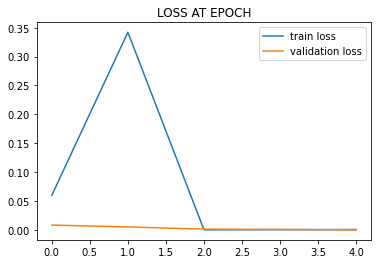

In [42]:
with torch.no_grad():
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('LOSS AT EPOCH')
    plt.legend()

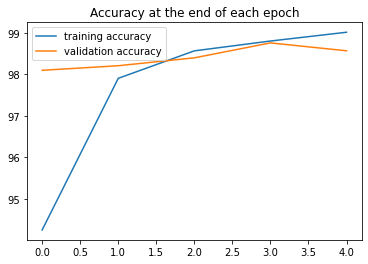

In [44]:
plt.plot([t / 600 for t in train_correct], label='training accuracy')
plt.plot([t / 100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [45]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [47]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [53]:
correct.item() * 100 / len(test_data)

98.57

In [54]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1, 10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 977    0    3    0    0    4    5    1    8    1]
 [   0 1129    2    0    1    0    3    9    1    3]
 [   0    1 1015    1    0    1    1    4    3    0]
 [   0    0    1 1006    0   10    0    1    1    1]
 [   0    0    1    0  978    0    1    1    3   11]
 [   0    2    0    1    0  870    0    0    0    2]
 [   1    2    1    0    2    4  947    0    0    0]
 [   2    1    7    0    0    1    0 1008    1    6]
 [   0    0    2    1    0    0    1    3  950    8]
 [   0    0    0    1    1    2    0    1    7  977]]


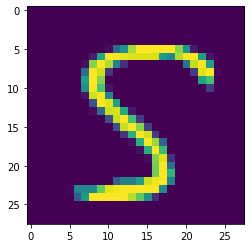

In [65]:
plt.imshow(test_data[333][0].reshape(28, 28))

In [66]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[333][0].view(1, 1, 28, 28))

In [67]:
new_prediction

tensor([[-1.8630e+01, -1.4021e+01, -1.9681e+01, -1.5024e+01, -2.3492e+01,
         -2.1551e-04, -1.0397e+01, -1.9039e+01, -8.7905e+00, -1.0359e+01]])

In [68]:
new_prediction.argmax()

tensor(5)